In [5]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import numpy as np
from math import gamma
from PIL import Image

## Background

The goal of this notebook is to demonstrate how to decipher the equivalent stress equation commonly provided in references such as MIL-HBDK-5J (now MMPDS). 

Section 9.6.1.4 in MIL-HDBK-5J provides background on the equivalent stress equation terms:

$
log N_f = A_1 + A_2 log (S_{eq} - A_4) \\
S_{eq} = S_{max}(1 - R)^{A_3}
$

This can be turned into the following Python function which solves for $N_f$ (cycles to failure):

In [3]:
def cycles_to_failure(R, s_max, A1, A2, A3, A4=0):
    """
    Cycle to failure calculation based on the equivlaent stress equation
        log N_f = A_1 + A_2 log (S_{eq} - A_4) \\
        S_{eq} = S_{max}(1 - R)^{A_3}   


    Parameters:
        R (float) : reversal type
        s_max (float) : max stress (ksi)
        A1 (float) 
        A2 (float) 
        A3 (float) 
        A4 (float) : default = 0
    """

    s_eq = s_max * (1 - R)**(A3)
    n_f = 10**(A1 - A2 * np.log10(s_eq - A4))
    return n_f

For Al6061-T6 the equivalent stress equation is given as:

$
log N_f = 20.68 - 9.84 log (S_{eq}) \\
S_{eq} = S_{max}(1 - R)^{0.63}
$

Based on general equation we can determine the $A_x$ terms: 

$ 
A_1 = 20.68 \\
A_2 = 9.84 \\
A_3 = 0.63 \\
A_4 = 0.0 \\
$


Let's recreate the Al6061-T6, $K_t$ = 0 SN figure from MIL-HBDK-5J shown below:

![6061_T6_SN.png](6061_T6_SN.png)

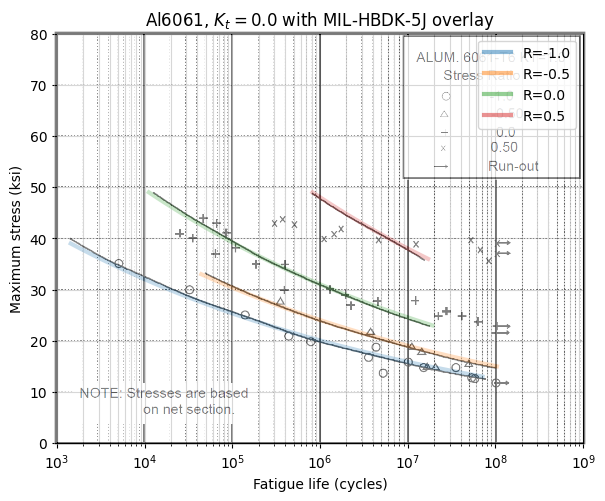

In [230]:
# Approximately the stress ranges values from the figure
cases = {
    -1.0 : np.arange(13.0, 40.0),
    -0.5 : np.arange(15.0, 33.5),
    0.0 : np.arange(23.0, 50.0),
    0.5 : np.arange(36.0, 50.0),   
}

hdbk_sn_figure = Image.open('SN_no_axes.png')
aspect_ratio = hdbk_sn_figure.width / hdbk_sn_figure.height
fig, ax = plt.subplots(figsize=(6, 4.9), layout="constrained")

for R, s_max in cases.items():
    n_f = cycles_to_failure(R, s_max, 20.68, 9.84, 0.63)
    ax.semilogx(n_f, s_max, label='R={}'.format(R), lw=3.0, alpha=0.5)

ax.grid(which='both')
ax.set_xlim(1e3, 1e9)
ax.set_ylim(0, 80)
ax.legend()
ax.set_alpha(0.1)

ax.set_xlabel('Fatigue life (cycles)')
ax.set_ylabel('Maximum stress (ksi)')
plt.title('Al6061, $K_t=0.0$ with MIL-HBDK-5J overlay')

imagebox = OffsetImage(hdbk_sn_figure, zoom = 0.40, alpha=0.5)
ab = AnnotationBbox(imagebox, (1e6, 40), frameon = False)
ax.add_artist(ab)

plt.show()

While the generated plot above appears similar to the MIL-HDBK-5J figure we can generate some quick tests where the curves pass major gridlines on both axes:
* R = -1.0 : 20 ksi, 1e6 cycles
* R = 0.0 : 40 ksi, 1e5 cycles

Ideally these tests would be in a separate file and a package such as pytest would be used to verify the tests are passed.

In [255]:
def test_cycles_to_failure_Rn1():
    R = -1
    s_max = 20.0
    output = cycles_to_failure(R, s_max, 20.68, 9.84, 0.63)
    assert np.isclose(output, 1e6, rtol=0.05)

test_cycles_to_failure_Rn1()

def test_cycles_to_failure_R0():
    R = 0.0
    s_max = 39.0
    output = cycles_to_failure(R, s_max, 20.68, 9.84, 0.63)
    assert np.isclose(output, 1e5, rtol=0.06)

test_cycles_to_failure_Rn1()
test_cycles_to_failure_R0()

# Rayleigh/narrowband fatigue damage calculation

P. Wirsching, T. Paez, K. Ortiz, Random Vibrations Theory and Practice, Dover, New York, 2006.

$
D = \frac{v^+_0 t}{A} (2 \sqrt{2} \sigma)^m \ \Gamma ( \frac{1}{2}m + 1 )
$ 

In [ ]:
def narrowband_fatigue(A, m, pcross, stress, t):
    r""" 
    Calculates fatigue damage assuming a Rayleigh distribution
    
    .. math::
        D = \frac{v^+_0 t}{A} (2 \sqrt{2} \sigma)^m \ \Gamma ( \frac{1}{2}m + 1 ).

    ### Parameters
    A (float) : fatigue strength coefficient from the material S-N curve, A=NS^m
    m (float) : fatigue exponent from the material S-N curve
    pcross (float) : positive crossing frequency (Hz)
    stress (float) : RMS stress (ksi)
    t (float) : time (s)

    ### Returns
    fatigue damage (unitless)  

    ### References
    [1] P. Wirsching, T. Paez, K. Ortiz, Random Vibrations Theory and Practice, Dover, New York, 2006.
    """

    assert A < 100

    A = 10**A
    D = (pcross * t) / A * (2 * np.sqrt(2) * stress)**m * gamma(0.5 * m + 1)
    return D


In [ ]:
max_stress = 10.0
positive_crossings = 100.
t_qual = 180.

narrowband_fatigue(20.84, 9.84, positive_crossings, max_stress, t_qual)

0.5231582811893852